In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/scaler_clustering.csv')

In [ ]:
print(df.head(30))
print(df.shape)

    Unnamed: 0                         company_hash  \
0            0                       atrgxnnt xzaxv   
1            1            qtrxvzwt xzegwgbb rxbxnta   
2            2                        ojzwnvwnxw vx   
3            3                            ngpgutaxv   
4            4                           qxen sqghu   
5            5  yvuuxrj hzbvqqxta bvqptnxzs ucn rna   
6            6                   lubgqsvz wyvot  wg   
7            7                 vwwtznhqt ntwyzgrgsj   
8            8                   utqoxontzn ojontbo   
9            9                                xrbhd   
10          10                      ztfstz ogenfvqt   
11          11                           ngdor ntwy   
12          12           mvqwrvjo wgqugqvnt mvzpxzs   
13          13                            wgszxkvzn   
14          14                               xznhxn   
15          15                               bgsrxd   
16          16                    pnw xzaxv ucn rna   
17        

In [ ]:
df.rename(columns={'Unnamed: 0':'ID'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [ ]:
df.isnull().sum()

ID                      0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [ ]:
df['email_hash'].value_counts()

email_hash
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66     8
                                                                    ..
bb2fe5e655ada7f7b7ac4a614db0b9c560e796bdfcaa4e5367e69eedfea93876     1
d6cdef97e759dbf1b7522babccbbbd5f164a75d1b4139e02c945958720f1ed79     1
700d1190c17aaa3f2dd9070e47a4c042ecd9205333545dbfaee0f85644d00306     1
c2a1c9e4b9f4e1ed7d889ee4560102c1e2235b2c1a0e59cea95a6fe55c658407     1
0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f7e738a6a87d3712c31     1
Name: count, Length: 153443, dtype: int64

In [ ]:
df['company_hash'].value_counts()

company_hash
nvnv wgzohrnvzwj otqcxwto         8337
xzegojo                           5381
vbvkgz                            3481
zgn vuurxwvmrt vwwghzn            3411
wgszxkvzn                         3240
                                  ... 
onvqmhwpo                            1
bvsxw ogenfvqt uqxcvnt rxbxnta       1
agsbv ojontbo                        1
vnnhzt xzegwgb                       1
bvptbjnqxu td vbvkgz                 1
Name: count, Length: 37299, dtype: int64

In [ ]:
df['ID'].value_counts()

ID
0         1
137694    1
137684    1
137685    1
137686    1
         ..
68713     1
68714     1
68715     1
68716     1
206922    1
Name: count, Length: 205843, dtype: int64

In [35]:
# df.groupby('email_hash')['ID'].agg('count').sort_values(ascending=False)

df_emailcounts=pd.DataFrame(df['email_hash'].value_counts().reset_index())
df_emailcounts.rename(columns={'count':'email_count'},inplace=True)

df_companycounts=pd.DataFrame(df['company_hash'].value_counts().reset_index())
df_companycounts.rename(columns={'count':'company_count'},inplace=True)


In [38]:
df=pd.merge(df,df_emailcounts)
df=pd.merge(df,df_companycounts)



In [39]:
df.sort_values(['company_count','email_count','ctc_updated_year'],ascending=[False,False,True]).head(20)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,email_count,company_count
49688,4401,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,NaN,2020.0,8,8337
49689,11337,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Data Scientist,2020.0,8,8337
49690,22427,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Frontend Engineer,2020.0,8,8337
49691,81153,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Other,2021.0,8,8337
49692,90953,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Backend Engineer,2021.0,8,8337
49693,93126,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Data Scientist,2021.0,8,8337
49694,107679,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,NaN,2021.0,8,8337
49695,132837,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Frontend Engineer,2021.0,8,8337
54156,131001,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,FullStack Engineer,2019.0,6,8337
54157,180041,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,Backend Engineer,2019.0,6,8337


# Unsure why there are duplicates of email_hash. Ideally this should be unique to each individual learner. However same value is linked with different job_profiles. For the rest of this analysis, I assume each row is a unique individual.

Top 10 companies learners are associated with

Text(0.5, 0, '')

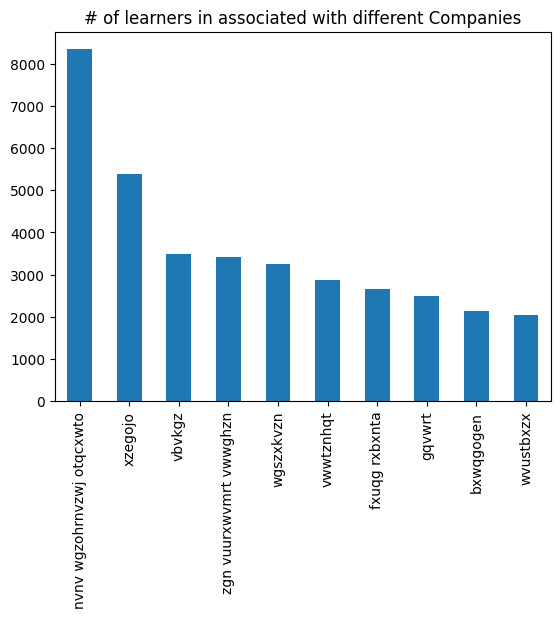

In [45]:
df['company_hash'].value_counts().head(10).plot(kind='bar')
plt.title('# of learners in associated with different Companies')
plt.xlabel('')

Top 10 roles learners are at

In [42]:
df['job_position'].value_counts().head(10).plot(kind='bar')
plt.title('Job positions of learners')
plt.xlabel('')

job_position
Backend Engineer          43553
FullStack Engineer        24714
Other                     18067
Frontend Engineer         10417
Engineering Leadership     6870
QA Engineer                6587
Data Scientist             5366
Android Engineer           5357
SDET                       4967
Devops Engineer            4612
Name: count, dtype: int64

ToDO

1. what is the typical time for promotion for different roles within and between companies?
2. What is the CTC difference between roles in a company and between companies
3. How did the learners joining scaler change in job role over time?
  **There are corrections needed in orgyear**






In [47]:
df['orgyear'].value_counts()

orgyear
2018.0    25247
2019.0    23420
2017.0    23234
2016.0    23042
2015.0    20606
          ...  
206.0         1
2107.0        1
208.0         1
1973.0        1
201.0         1
Name: count, Length: 77, dtype: int64